In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from scipy.signal import find_peaks
import random
import math 

# Set random seed
np.random.seed(42)

# Data Importation and Visualization

In [2]:
def load_and_visualize_data(file_path):
    # Load the CSV file into a DataFrame
    data = pd.read_csv(file_path)  # Adjust depending on file format
    
    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(data["timestamp"], data["value"], label="Time Series Data", linewidth=1)
    plt.xticks(np.arange(0, len(data["timestamp"]), 2*24*30), rotation=45)  # Show every 30 days
    plt.title("Time Series Data (30-minute intervals)")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(visible=True, linestyle='--', alpha=0.6)  # Add a grid for better readability
    
    # Display the plot
    plt.show()
    
    return data

In [6]:
%matplotlib inline

In [5]:
file_path = "nyc_taxi.csv"  # Replace with your data file
data = load_and_visualize_data(file_path)

In [48]:
ts = list(data["value"])

In [49]:
# Pattern length is a day (48 half-hour intervals)
pattern_length = 24*2

In [50]:
true_anomalies = [
        "2014-11-01 19:00:00",
        "2014-11-27 15:30:00",
        "2014-12-25 15:00:00",
        "2015-01-01 01:00:00",
        "2015-01-27 00:00:00"
    ]

# Norma implementation

In [51]:
def extract_recurrent_sequences_random(ts, normalmodel_size, 
                                       percentage_sel = 0.2, overlapping_factor=0.5):
    """
    		INPUT
   			ts: a list representing the time series
   			normalmodel_size: an integer representing the size of the normalmodel
   							  you want to generate 
                              3*pattern_length in the paper
   			percentage_sel: the percentage of the dataset to sample respect to
   							all the possible sequences to select (depends also on the overlapping_factor).
   							Values range between [0-1]
   			overlapping_factor: the overlapping factor to exclude:
    								1 is no overlapping, 0 is total overlapping allowed.
    								Values range between [0-1]
                                    0.5 in the paper
    		OUTPUT
   			tuple(recurrent_sequence, sequence_rec)
    
   			recurrent_sequence: a numpy array of the recurrent sequences
   			sequence_rec: a list of couple(start,end) of each recurrent sequence in the original time series
    """

    recurrent_sequence = pd.DataFrame()
    sequence_rec = []

    # Draw reccurent_seq_num indexes from the possible ones
    # With the constraint of the overlapping factor

    possible_idx = list(range(len(ts)- normalmodel_size))
    while len(sequence_rec) < int(len(ts)*percentage_sel/(normalmodel_size*overlapping_factor)) and len(possible_idx) > 0:
        idx = random.choice(possible_idx)
        sequence_rec.append((idx,idx+normalmodel_size))
        # Remove the selected index and the ones that are too close
        possible_idx = [x for x in possible_idx if abs(x-idx) > normalmodel_size*overlapping_factor]
    
    # Extract the recurrent sequences
    for i, (start, end) in enumerate(sequence_rec):
        recurrent_sequence[str(i)] = ts[start:end]

    return recurrent_sequence, sequence_rec


def returnClustersMDL_AndSumMDL(dataFrameSubsequences, clusterNumbers):

    def findValuesSax(real):
        saxBP = [-1.53, -1.15, -0.89, -0.67, -0.49, -0.32, -0.16, 0, 0.16, 0.32, 0.49, 0.67, 0.89, 1.15, 1.53]
        # global saxBP
        pos=0
        for x in saxBP:
            if real>x:
                pos+=1
            else:
                break
        return pos

    def computeEntropy(T):
        D={}
        for p in T:
            x = findValuesSax(p)
            if x in D:
                D[x] = D[x] +1
            else:
                D[x] =  1

        entropy = 0
        # nKeys = len(D.keys())
        for k in D.keys():
        #probability of key
            prob = float(D[k])/float(len(T))
            logProb = math.log(prob,2)
            entropy = entropy + prob*logProb

        entropy = -1 * entropy
        return entropy

    def computeDescriptionLength(T):
        return (len(T) * computeEntropy(T))

    def computeCondDescLength(A,B):
        diff = np.subtract(A,B)
        return computeDescriptionLength(diff)

    Cluster ={}
    ClustersCenters = {}
    numberElementsCluster = {}

    for i in range(len(clusterNumbers)):
        clNunmb = clusterNumbers[i]
        if clNunmb in ClustersCenters:
            listA = dataFrameSubsequences[str(i)].values
            listB = ClustersCenters[clNunmb]
            ClustersCenters[clNunmb] = np.add(listA, listB)
            Cluster[clNunmb].append(dataFrameSubsequences[str(i)].values)
            numberElementsCluster[clNunmb] +=1
        else:
            ClustersCenters[clNunmb]= dataFrameSubsequences[str(i)].values
            Cluster[clNunmb] = [dataFrameSubsequences[str(i)].values]
            numberElementsCluster[clNunmb] = 1

    MdlClusetrs ={}
    BitSaveCluster = {}
    minDl = 0
    maxDl = 0
    minDlCenter = None
    bFirst=True
    numberClusterBest = 0
    sumUptotalMDL = 0
    totalBitSavedClusters = 0
    for k in Cluster.keys():
        maxDlCl = 0
        sumDlCl = 0
        listSeq = Cluster[k]
        center = [ (i/numberElementsCluster[k]) for i in ClustersCenters[k]]
        desL = computeDescriptionLength(center)
        totalBitSeq = 0
        for seq in listSeq:
            dlCond = computeCondDescLength(seq,center)
            sumDlCl = sumDlCl+dlCond
            maxDlCl= max(maxDlCl,dlCond)
            totalBitSeq+=computeDescriptionLength(seq)

        dlc = desL - maxDlCl + sumDlCl
        MdlClusetrs[k] = dlc
        totalBitSave = totalBitSeq-dlc
        BitSaveCluster[k] = totalBitSave
        totalBitSavedClusters+=totalBitSave
        if(bFirst):
            bFirst=False
            minDl = dlc
            maxDl = dlc
            numberClusterBest = k
            minDlCenter = center
        else:
            minDl = min(dlc,minDl)
            maxDl = max(dlc,maxDl)
            if(minDl==dlc):
                minDlCenter = center
                numberClusterBest = k
        sumUptotalMDL+=dlc

    return MdlClusetrs, minDlCenter, numberClusterBest, sumUptotalMDL, BitSaveCluster, totalBitSavedClusters


def cluster_sequences_hierarchical(sequences, n_clusters=-1):
    """
    Cluster the sequences using the hierarchical method and number of clusters.
    INPUT 
    sequences: a dataframe containing the sequences to cluster
    n_clusters: the number of clusters to use (automatically determined if -1, as in the paper with the Minimum Description Length criterion)
    OUTPUT
    labels: an array containing the cluster labels for each sequence
    """

    # Distance matrix, distance is the Z-normalized Euclidean distance
    df = pd.DataFrame(sequences).T
    # Z-normalize each sequence (along the rows)
    df_normalized = (df - df.mean(axis=1).values[:, None]) / df.std(axis=1).values[:, None]
    distances = pdist(df_normalized, metric='euclidean')

    # Hierarchical clustering
    linkage_matrix = linkage(distances, method='ward')
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix)
    plt.title("Hierarchical Clustering Dendrogram of Sequences")
    plt.show()

    if n_clusters == -1:
        # Automatically determine the number of clusters with MDL Top Down
        DicBitSavedForCluster = None
        totalBitSaved = None
        start = max(0,distances.max()-0.0001) # starting point (top cut)
        end =  max(0,distances.min()-0.0001) # end point top cut
        listclusterUpperMost= fcluster(linkage_matrix, start, 'distance')
        nunmberOfCluster = len(set(listclusterUpperMost))
        setDisttemp = set(distances) - set([distances.min()])
        step = np.min(list(setDisttemp)) - distances.min()

        #time saver 
        step = max(step,0.0001)
        
        listClusterReturn = listclusterUpperMost
        DdlClusters, centerWithMinDl, chosenCluster, sumDl, DicBitSavedForCluster, totalBitSaved = returnClustersMDL_AndSumMDL(sequences, listClusterReturn)
        lastNumberCluster = nunmberOfCluster
        # lastSumDL = sumDl
        # bestCenter = centerWithMinDl
        # bestChosenClusterNumber = chosenCluster
        level = start-step

        while (level>=end):
            listclusterActual= fcluster(linkage_matrix, level, 'distance')
            nunmberOfCluster = len(set(listclusterActual))
            if(lastNumberCluster<nunmberOfCluster):
                DdlClusters, centerWithMinDl, chosenCluster, sumDl, DicBitSavedForClusterAc,totalBitSavedAc = returnClustersMDL_AndSumMDL(sequences,listclusterActual)
                lastNumberCluster = nunmberOfCluster
                if(totalBitSaved<totalBitSavedAc):
                    totalBitSaved = totalBitSavedAc
                    # lastSumDL=sumDl
                    # bestCenter = centerWithMinDl
                    # bestChosenClusterNumber = chosenCluster
                    listClusterReturn = listclusterActual
                else:
                    break
            level = level - step
        labels = listClusterReturn
    else:
        labels = fcluster(linkage_matrix, n_clusters, 'maxclust')
    
    print("Number of sequences :", len(sequences.T))
    print("Number of clusters:", len(set(labels)))

    return labels, distances


def normal_model_builder(labels, sequences, sequence_rec):
    """
    INPUT
    labels: an array containing the cluster labels for each sequence
    sequences: a dataframe containing the sequences clustered, size (n_features, number of sequences)
    sequence_rec: a list of couple(start,end) of each recurrent sequence in the original time series

    Build the normal model using the clusters and sequences.
    In the paper, the normal is the centroid of the cluster that minimizes a function
    """

    normal_model = []
    centroids = {}
    for cluster in set(labels):
        # Extract the sequences in the cluster
        cluster_sequences = sequences.iloc[:, [i for i in range(sequences.shape[1]) if labels[i] == cluster]]
        cluster_sequence_rec = [sequence_rec[i] for i in range(len(sequence_rec)) if labels[i] == cluster]
        # Compute the centroid of the cluster
        centroid = cluster_sequences.mean(axis=1)
        centroids[cluster] = centroid
    for cluster in set(labels):
        # Compute the weight of the cluster
        frequency =  cluster_sequences.shape[1] / sequences.shape[1]
        # Compute the coverage of the cluster : time interval between the first and the last occurence of a subsequence in c
        coverage = max([end-start for start, end in cluster_sequence_rec])
        # Compute sum of distances to other centroids
        isolation = 0
        for other_cluster in set(labels):
            if other_cluster != cluster:
                isolation += np.linalg.norm(centroids[cluster] - centroids[other_cluster])
        weight = frequency**2 * coverage / isolation
        normal_model.append((centroids[cluster], weight))

    # Sort the normal model by decreasing weight
    normal_model = sorted(normal_model, key=lambda x: x[1])[::-1]

    # In the paper, the normal model is the cluster centroid with the highest weight
    return [normal_model[0]]


def compute_scores(ts, normal_model, pattern_length=pattern_length):
    """
    Compute the anomaly scores for the time series using the normal model.
    INPUT
    ts: a list representing the time series
    normal_model: a list of (sequence, weight) tuples representing the normal model
    OUTPUT
    scores: a list of anomaly scores for the time series
    """

    scores = []
    for i in range(len(ts) - pattern_length):
        subseq = ts[i:i + pattern_length]
        subseq = (subseq - np.mean(subseq)) / np.std(subseq)
        # Compute the weighted distance to the normal model sequences
        score = 0
        for seq, weight in normal_model:
            min_dist = float("inf")
            for j in range(len(seq)-pattern_length):
                subseq2 = seq[j:j + pattern_length]
                subseq2 = (subseq2 - np.mean(subseq2)) / np.std(subseq2)
                dist = np.linalg.norm(subseq - subseq2)
                min_dist = min(min_dist, dist)
            score += weight * min_dist
        scores.append(score)

    # Normalize the scores
    scores = np.array(scores)
    return (scores - scores.mean()) / scores.std()

# Norma visualization

In [52]:
recurrent_sequence, sequence_rec = extract_recurrent_sequences_random(ts, 7*pattern_length, percentage_sel=1.0, overlapping_factor=0.5)

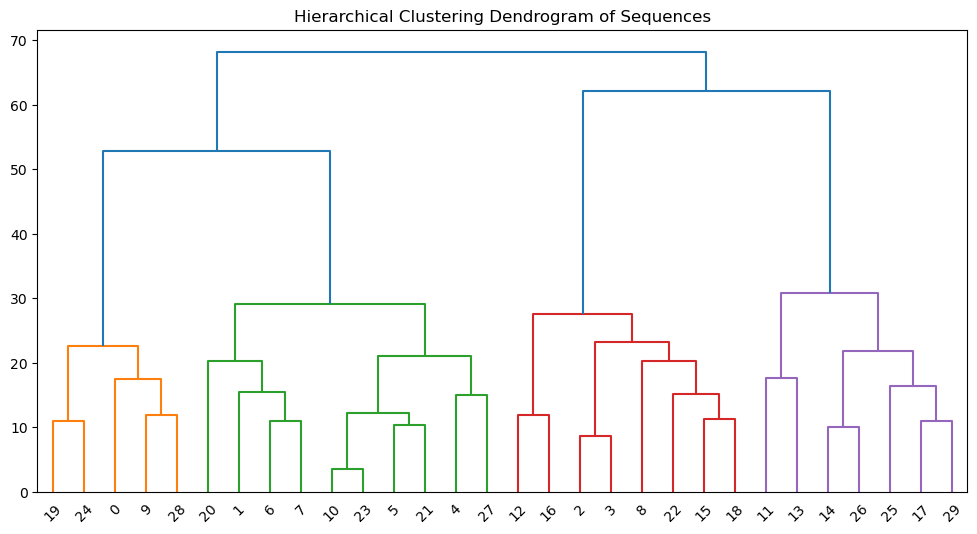

Number of sequences : 30
Number of clusters: 6


In [53]:
labels, distances = cluster_sequences_hierarchical(recurrent_sequence, n_clusters=6)

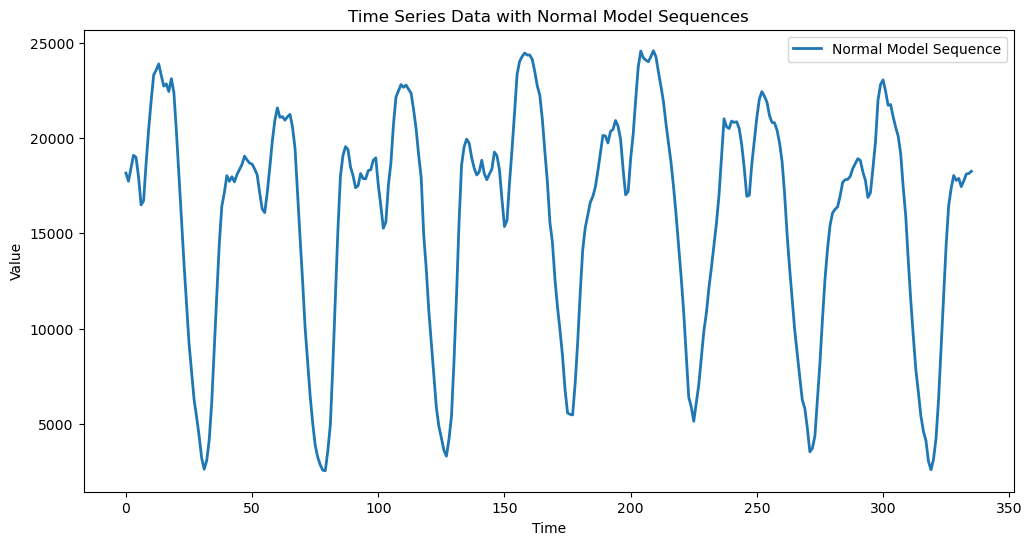

In [54]:
# Build the normal model
normal_model = normal_model_builder(labels, recurrent_sequence, sequence_rec)

# Plot the normal model
plt.figure(figsize=(12, 6))
for seq, weight in normal_model:
    plt.plot(seq, label="Normal Model Sequence", linewidth=2)
plt.title("Time Series Data with Normal Model Sequences")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [55]:
# Compute the anomaly scores
scores = compute_scores(ts, normal_model)

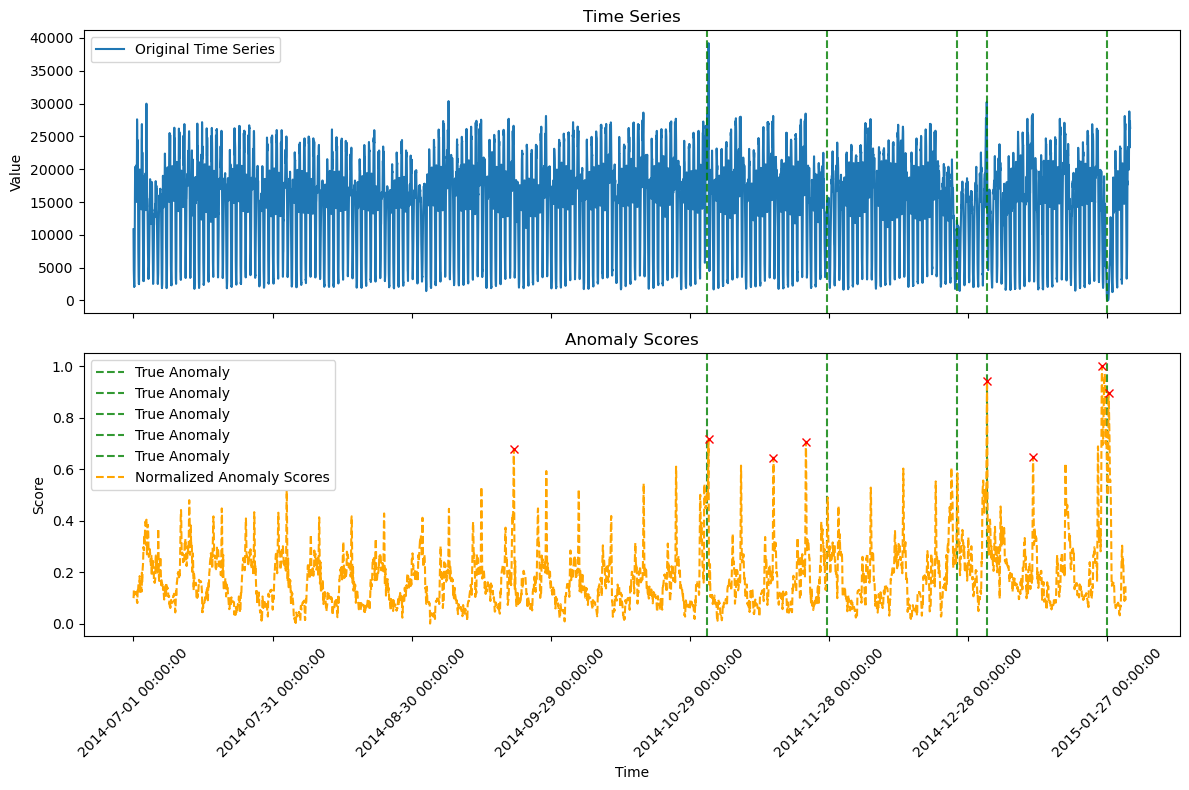

In [56]:
def plot_scores(ts, scores, number_of_anomalies=8):
    scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot time series
    axs[0].plot(data["timestamp"], data["value"], label="Original Time Series")
    # Plot less ticks for better readability
    axs[0].set_xticks(data["timestamp"][::30*24*2])  # Show every 30 days
    axs[0].tick_params(axis="x", rotation=90)
    axs[0].set_title("Time Series")
    axs[0].set_ylabel("Value")
    axs[0].legend()
    # Plot anomalies in the time series 

    for anomaly in true_anomalies:
        axs[0].axvline(x=anomaly, color="green", linestyle="--", alpha=0.8, label="True Anomaly")
        axs[1].axvline(x=anomaly, color="green", linestyle="--", alpha=0.8, label="True Anomaly")
    
    # Plot normalized anomaly scores
    axs[1].plot(scores, label="Normalized Anomaly Scores", color='orange', linestyle="--")
    axs[1].set_title("Anomaly Scores")
    axs[1].tick_params(axis="x", rotation=45)
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("Score")
    axs[1].legend()

    # Identify number_of_anomalies spikes in the anomaly scores
    peaks, _ = find_peaks(scores, distance=pattern_length)
    peak_values = [scores[p] for p in peaks]
    top_indexes = peaks[np.argsort(peak_values)[-number_of_anomalies:]]
    top_values = [(index, scores[index]) for index in top_indexes]
    axs[1].plot(top_indexes, [scores[i] for i in top_indexes], "x", color='red', label="Anomalies")

    plt.tight_layout()
    plt.show()

# Visualize results
plot_scores(ts, scores)